# Visualise course overview with Sankey diagram

In [1]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import plotly.graph_objs as go

## Load all weekly responses

In [2]:
# Load weekly .csv files from Moodle
files = [f for f in listdir('../data') if isfile(join('../data', f))]
course = pd.DataFrame()
for f, file in enumerate(files[:-1]):
    week = pd.read_csv('../data/'+file)
    week.set_index('Username', inplace=True)
    week.rename(columns={"Grade/100.00": file[:-4]}, inplace=True)
    week = week[file[:-4]]
    course = pd.concat([course, week], axis=1, join='outer')
course

,Week1,Week2,Week3,Week4,Week5,Week7,Week8
id_85432856,100.0,85.0,100.0,100.0,50.00,100.0,93.75
id_98909797,97.0,100.0,100.0,100.0,100.00,60.0,100.00
id_34152306,94.0,100.0,100.0,100.0,100.00,100.0,100.00
id_68247223,100.0,100.0,100.0,100.0,100.00,100.0,100.00
id_79192121,100.0,95.0,100.0,100.0,66.67,100.0,100.00
...,...,...,...,...,...,...,...
id_43110593,NaN,95.0,100.0,100.0,100.00,100.0,100.00
id_79451481,NaN,100.0,NaN,NaN,NaN,NaN,NaN
id_65441675,NaN,65.0,100.0,100.0,66.67,100.0,NaN
id_87923109,NaN,70.0,NaN,100.0,50.00,100.0,100.00


## Convert to grades

In [3]:
def mark_to_grade(x):
    '''
    Function to map marks (out of 100) to grades.
    '''
    if isinstance(x, str):
        return x
    elif pd.isna(x):
        return 'FL'
    elif x >= 85:
        return 'HD'
    elif x >= 75:
        return 'D'
    elif x >= 65:
        return 'CR'
    elif x >= 50:
        return 'PS'
    else:
        return 'FL'

In [4]:
# Apply marks to grade mapping
grades = course.map(mark_to_grade)
grades

,Week1,Week2,Week3,Week4,Week5,Week7,Week8
id_85432856,HD,HD,HD,HD,PS,HD,HD
id_98909797,HD,HD,HD,HD,HD,PS,HD
id_34152306,HD,HD,HD,HD,HD,HD,HD
id_68247223,HD,HD,HD,HD,HD,HD,HD
id_79192121,HD,HD,HD,HD,CR,HD,HD
...,...,...,...,...,...,...,...
id_43110593,FL,HD,HD,HD,HD,HD,HD
id_79451481,FL,HD,FL,FL,FL,FL,FL
id_65441675,FL,CR,HD,HD,CR,HD,FL
id_87923109,FL,CR,FL,HD,PS,HD,HD


## Visualise using Sankey diagrams 

In [5]:
# Define grade order and colours
grade_order = ["HD", "D", "CR", "PS", "FL"]
grade_colors = {
    "HD": "green",
    "D": "blue",
    "CR": "teal",
    "PS": "yellow",
    "FL": "red"
}

In [6]:
# Get transitions between consecutive weeks
weeks = grades.columns.tolist()
transitions = []
for i in range(len(weeks)-1):
    w1, w2 = weeks[i], weeks[i+1]
    pairs = grades[[w1, w2]].value_counts().reset_index()
    pairs.columns = ['source_grade', 'target_grade', 'count']
    pairs['source_grade'] = pd.Categorical(pairs['source_grade'], categories=grade_order, ordered=True)
    pairs['target_grade'] = pd.Categorical(pairs['target_grade'], categories=grade_order, ordered=True)
    pairs = pairs.sort_values(by=['source_grade','target_grade'])
    pairs['source_week'] = w1
    pairs['target_week'] = w2
    transitions.append(pairs)
transitions_df = pd.concat(transitions, ignore_index=True)

# Create ordered node labels and colours by grade and week
all_labels = []
for week in weeks:
    for grade in grade_order:
        all_labels.append(f"{grade} {week}")  # always include every grade per week
label_to_index = {label: i for i, label in enumerate(all_labels)}
node_colors = [grade_colors[grade] for week in weeks for grade in grade_order]

# Build Sankey lists
sources = np.array(transitions_df.apply(lambda r: label_to_index[f"{r['source_grade']} {r['source_week']}"], axis=1), dtype='int')
targets = np.array(transitions_df.apply(lambda r: label_to_index[f"{r['target_grade']} {r['target_week']}"], axis=1), dtype='int')
values = np.array(transitions_df['count'], dtype='int')

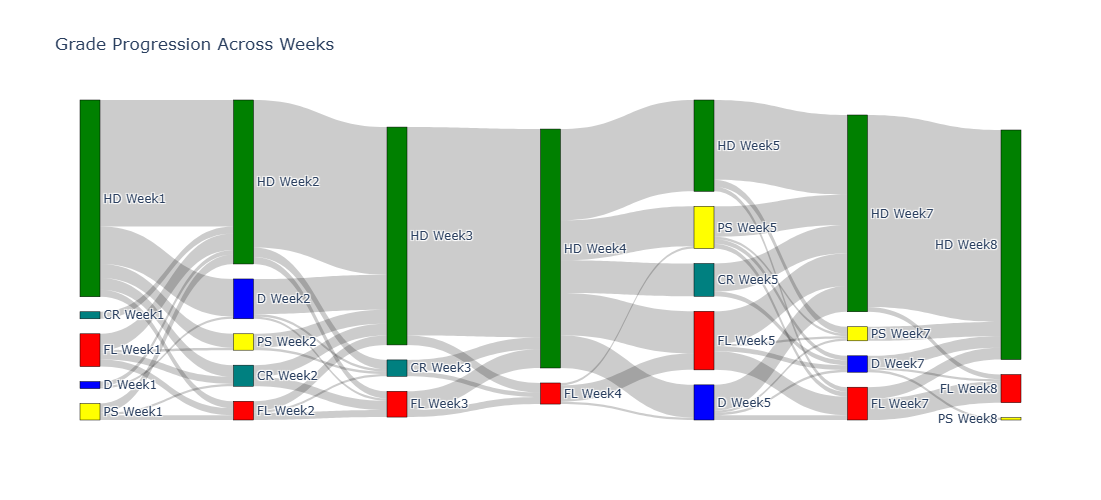

In [15]:
# Build Sankey diagram
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_labels,
        color=node_colors
    ),
    link=dict(
        source=sources, 
        target=targets, 
        value=values
    )
    )],
    layout=go.Layout(autosize=False, width=1000, height=500)
)

fig.update_layout(title_text="Grade Progression Across Weeks", font_size=12)
fig.write_image(join("images", "weekly.png"), engine='orca')
fig.show()